In [ ]:
from google.cloud import bigquery as bq

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind

In [ ]:
conn = bq.Client.from_service_account_json("case.json")

In [ ]:
query_ab_1 = """
-- Counts the number of unique users in each A/B test group.
-- Helps verify the distribution of users across test groups.

SELECT
  group_id,
  COUNT(DISTINCT user_id) AS users
FROM case_db.q2_table_ab_test_enter
GROUP BY group_id;

"""

In [ ]:
 df_ab_1 = conn.query(query_ab_1).to_dataframe()

In [ ]:
df_ab_1

,group_id,users
0,A,37188
1,B,36262


# Monetization A/B Test

### What is a Monetization A/B Test?

A **Monetization A/B Test** is an experiment designed to compare different monetization strategies (e.g., pricing models, offers, or feature access) across user groups to evaluate which variant performs better in terms of revenue generation.

---

### Why is it important?

- **Data-Driven Decisions**: Helps optimize monetization by relying on user behavior rather than assumptions.
- **Revenue Impact Analysis**: Identifies which approach maximizes revenue or improves conversion rates.
- **User Experience Testing**: Measures trade-offs between monetization and user engagement.
- **Risk Minimization**: Tests new strategies on a subset of users before a full rollout.

---

### How is it done?

1. **Group Assignment**: Users are randomly split into control and test groups (e.g., A vs B).
2. **Metric Tracking**: Key metrics are collected per group, such as:
   - Conversion Rate
   - Average Revenue Per User (ARPU)
   - Revenue per Paying User
   - Time to First Purchase
3. **Statistical Analysis**: Results are compared to determine if the differences are statistically and practically significant.
4. **Decision Making**: The best-performing variant is selected for broader implementation.

---

In [ ]:
query_ab_2 = """
-- Calculates core monetization metrics per A/B test group.
-- Measures performance via conversion, revenue, and behavioral timing.

WITH user_groups AS (
  SELECT
    user_id,
    group_id,
    TIMESTAMP_TRUNC(test_entry_timestamp, DAY) AS install_date
  FROM case_db.q2_table_ab_test_enter
),

first_purchases AS (
  SELECT
    user_id,
    MIN(TIMESTAMP_TRUNC(event_timestamp, DAY)) AS first_purchase_date
  FROM case_db.q2_table_ab_test_revenue
  GROUP BY user_id
),

user_revenue AS (
  SELECT
    r.user_id,
    r.dollar_amount,
    TIMESTAMP_TRUNC(r.event_timestamp, DAY) AS revenue_date
  FROM case_db.q2_table_ab_test_revenue r
)

SELECT
  g.group_id,
  COUNT(DISTINCT g.user_id) AS total_users,
  COUNT(DISTINCT ur.user_id) AS paying_users,
  ROUND(SAFE_DIVIDE(COUNT(DISTINCT ur.user_id), COUNT(DISTINCT g.user_id)) * 100, 2) AS conversion_rate,
  SUM(ur.dollar_amount) AS total_revenue,
  ROUND(SAFE_DIVIDE(SUM(ur.dollar_amount), COUNT(DISTINCT g.user_id)), 2) AS arpu,
  ROUND(SAFE_DIVIDE(SUM(ur.dollar_amount), COUNT(DISTINCT ur.user_id)), 2) AS revenue_per_paying_user,
  ROUND(AVG(DATE_DIFF(fp.first_purchase_date, g.install_date, DAY)), 2) AS avg_days_to_first_purchase
FROM user_groups g
LEFT JOIN user_revenue ur ON g.user_id = ur.user_id
LEFT JOIN first_purchases fp ON g.user_id = fp.user_id
GROUP BY g.group_id
ORDER BY g.group_id;

"""


In [ ]:
 df_ab_2 = conn.query(query_ab_2).to_dataframe()

In [ ]:
df_ab_2

,group_id,total_users,paying_users,conversion_rate,total_revenue,arpu,revenue_per_paying_user,avg_days_to_first_purchase
0,A,37188,2782,7.48,439673.0,11.82,158.04,6.28
1,B,36262,3261,8.99,552916.0,15.25,169.55,5.54


#Key Insights

- **Group B** outperformed Group A across **all monetization metrics**, suggesting a more effective variant.
- Conversion rate increased by over **20%**, and **total revenue** was ~27% higher in Group B.
- **ARPU** and revenue per paying user are both meaningfully higher in Group B.
- Group B users also made their **first purchase faster**, indicating stronger early engagement.

**Group B appears to be the winning variant.** Consider further statistical testing before rollout.

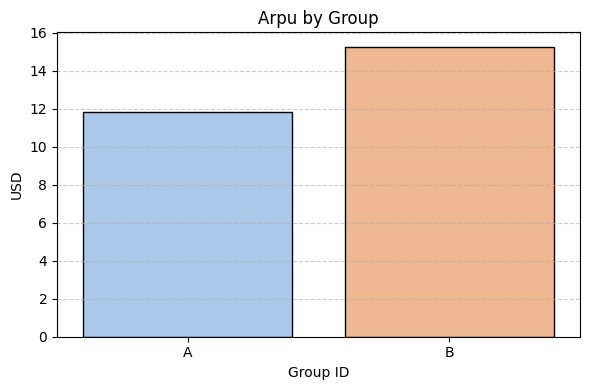

/tmp/ipython-input-30-3823022144.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_ab_2, x='group_id', y=metric, palette='pastel', edgecolor='black')


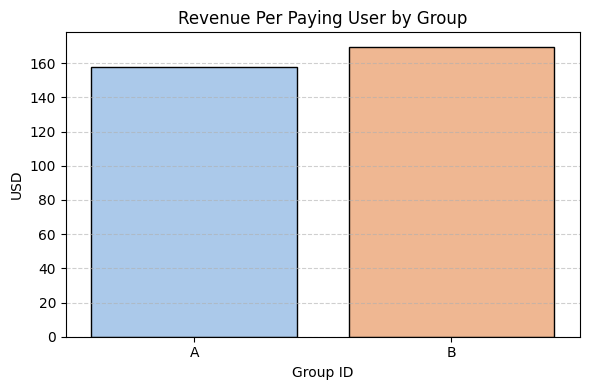

/tmp/ipython-input-30-3823022144.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_ab_2, x='group_id', y='conversion_rate', palette='muted', edgecolor='black')


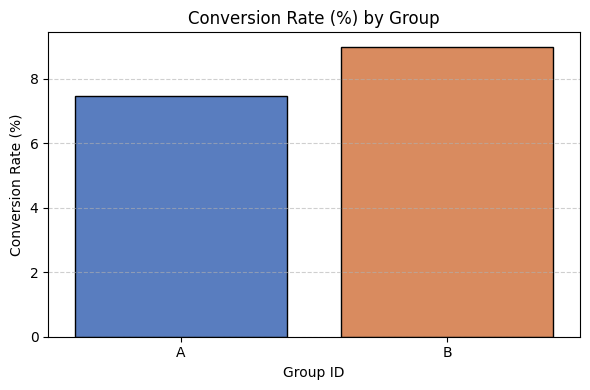

/tmp/ipython-input-30-3823022144.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_ab_2, x='group_id', y='avg_days_to_first_purchase', palette='Blues', edgecolor='black')


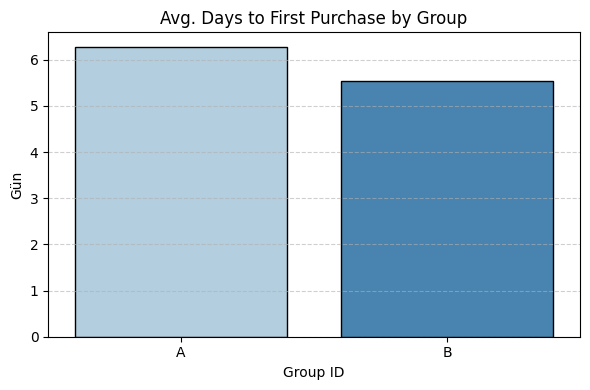

In [ ]:
metrics_to_plot = ['arpu', 'revenue_per_paying_user']
for metric in metrics_to_plot:
    plt.figure(figsize=(6, 4))
    sns.barplot(data=df_ab_2, x='group_id', y=metric, palette='pastel', edgecolor='black')
    plt.title(f"{metric.replace('_', ' ').title()} by Group")
    plt.ylabel("USD")
    plt.xlabel("Group ID")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(6, 4))
sns.barplot(data=df_ab_2, x='group_id', y='conversion_rate', palette='muted', edgecolor='black')
plt.title("Conversion Rate (%) by Group")
plt.ylabel("Conversion Rate (%)")
plt.xlabel("Group ID")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.barplot(data=df_ab_2, x='group_id', y='avg_days_to_first_purchase', palette='Blues', edgecolor='black')
plt.title("Avg. Days to First Purchase by Group")
plt.ylabel("Gün")
plt.xlabel("Group ID")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


#Engagement A/B Test

# What is an Engagement A/B Test?

An **Engagement A/B Test** evaluates how different variants of an app or feature affect user interaction and behavior. It focuses on user activity metrics rather than monetization outcomes.

---

### Why is it important?

- **User Retention**: Helps identify features or experiences that keep users active and coming back.
- **Product Optimization**: Informs design and UX improvements based on real user behavior.
- **Progression Insights**: Measures how changes impact time spent, session frequency, and user progression.
- **Data-Driven UX Decisions**: Ensures updates improve—not harm—overall user engagement.

---

### How is it done?

1. **User Segmentation**: Users are randomly assigned to A/B groups, each experiencing a different version of the product.
2. **Metric Collection**: Key engagement metrics are tracked per group, such as:
   - Total and average number of sessions
   - Total and average time spent
   - Average session length
   - Average level or progress reached
3. **Comparison and Analysis**: Differences across groups are analyzed to evaluate impact.
4. **Actionable Decisions**: Winning variant is used to inform broader product updates.

---


In [ ]:
query_ab_3 = """
-- Calculates user engagement metrics per A/B test group.
-- Measures behavioral activity including session frequency, time spent, and progression.

WITH user_groups AS (
  SELECT
    user_id,
    group_id
  FROM case_db.q2_table_ab_test_enter
),

session_data AS (
  SELECT
    user_id,
    time_spent,
    level
  FROM case_db.q2_table_ab_test_session
)

SELECT
  g.group_id,
  COUNT(DISTINCT g.user_id) AS total_users,
  COUNT(s.user_id) AS total_sessions,
  ROUND(SAFE_DIVIDE(COUNT(s.user_id), COUNT(DISTINCT g.user_id)), 2) AS avg_sessions_per_user,
  ROUND(SUM(s.time_spent), 2) AS total_time_spent,
  ROUND(SAFE_DIVIDE(SUM(s.time_spent), COUNT(DISTINCT g.user_id)), 2) AS avg_time_spent_per_user,
  ROUND(SAFE_DIVIDE(SUM(s.time_spent), COUNT(s.user_id)), 2) AS avg_time_per_session,
  ROUND(AVG(s.level), 2) AS avg_level_reached
FROM user_groups g
LEFT JOIN session_data s ON g.user_id = s.user_id
GROUP BY g.group_id
ORDER BY g.group_id;

"""

In [ ]:
 df_ab_3 = conn.query(query_ab_3).to_dataframe()

In [ ]:
df_ab_3

,group_id,total_users,total_sessions,avg_sessions_per_user,total_time_spent,avg_time_spent_per_user,avg_time_per_session,avg_level_reached
0,A,37188,128173351,3446.63,3.706398e+09,99666.51,28.92,477.62
1,B,36262,95970948,2646.60,2.758156e+09,76061.89,28.74,271.96


# Key Insights

- **Group A** users were significantly more engaged in terms of:
  - Total sessions (+33%)
  - Time spent per user (+31%)
  - Game progression (avg. levels reached nearly **2×** Group B)
- Session length was **similar** across groups, indicating similar per-session experience.

Despite **higher monetization in Group B**, Group A exhibits **superior engagement** metrics.
Consider whether changes in Group B are inadvertently suppressing engagement in favor of revenue.

/tmp/ipython-input-24-2755406687.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_ab_3, x='group_id', y=metric, palette='Set2', edgecolor='black')


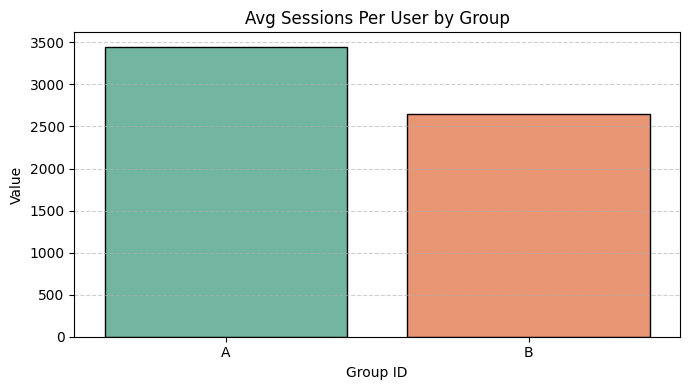

/tmp/ipython-input-24-2755406687.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_ab_3, x='group_id', y=metric, palette='Set2', edgecolor='black')


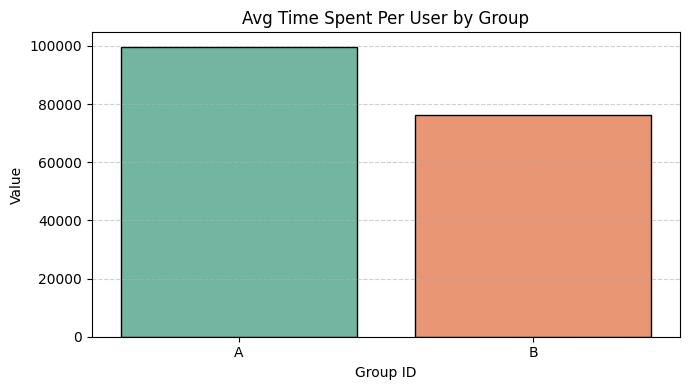

/tmp/ipython-input-24-2755406687.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_ab_3, x='group_id', y=metric, palette='Set2', edgecolor='black')


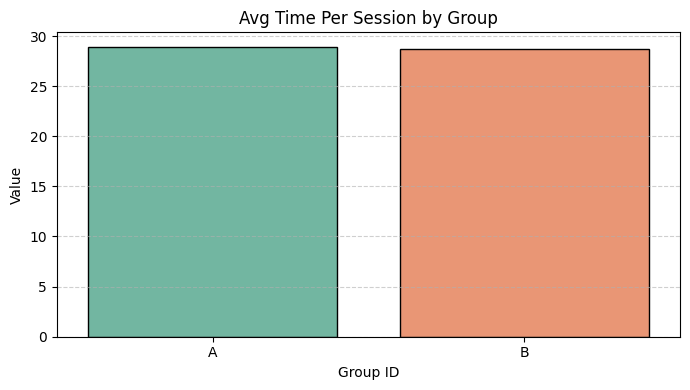

/tmp/ipython-input-24-2755406687.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_ab_3, x='group_id', y=metric, palette='Set2', edgecolor='black')


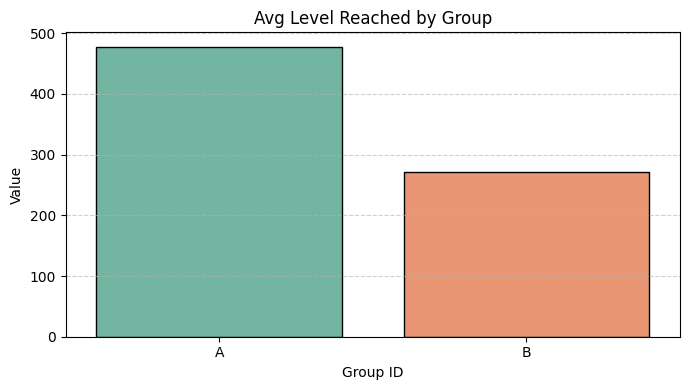

In [ ]:

metrics = ['avg_sessions_per_user', 'avg_time_spent_per_user', 'avg_time_per_session', 'avg_level_reached']

for metric in metrics:
    plt.figure(figsize=(7, 4))
    sns.barplot(data=df_ab_3, x='group_id', y=metric, palette='Set2', edgecolor='black')
    plt.title(f"{metric.replace('_', ' ').title()} by Group")
    plt.xlabel("Group ID")
    plt.ylabel("Value")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()